Cities:
City 0: (38, 37)
City 1: (91, 68)
City 2: (82, 35)
City 3: (83, 59)
City 4: (92, 59)
City 5: (14, 0)
City 6: (88, 55)
City 7: (75, 36)
City 8: (74, 67)
City 9: (10, 30)
City 10: (98, 65)
City 11: (95, 74)
City 12: (83, 96)
City 13: (86, 65)
City 14: (17, 27)
City 15: (58, 96)
City 16: (94, 21)
City 17: (57, 56)
City 18: (87, 91)
City 19: (65, 34)
City 20: (43, 84)
City 21: (60, 96)
City 22: (18, 40)
City 23: (1, 70)
City 24: (45, 78)
City 25: (99, 70)
City 26: (28, 44)
City 27: (72, 29)
City 28: (64, 50)
City 29: (25, 32)
City 30: (91, 18)
City 31: (43, 28)
City 32: (87, 31)
City 33: (60, 73)
City 34: (28, 100)
City 35: (34, 73)
City 36: (54, 87)
City 37: (49, 18)
City 38: (13, 36)
City 39: (82, 47)
City 40: (29, 19)
City 41: (36, 15)
City 42: (82, 84)
City 43: (26, 14)
City 44: (49, 23)
City 45: (14, 94)
City 46: (50, 27)
City 47: (44, 95)
City 48: (39, 43)
City 49: (9, 49)
City 50: (5, 37)
City 51: (76, 68)
City 52: (30, 74)
City 53: (26, 56)
City 54: (100, 50)
City 55: (65, 

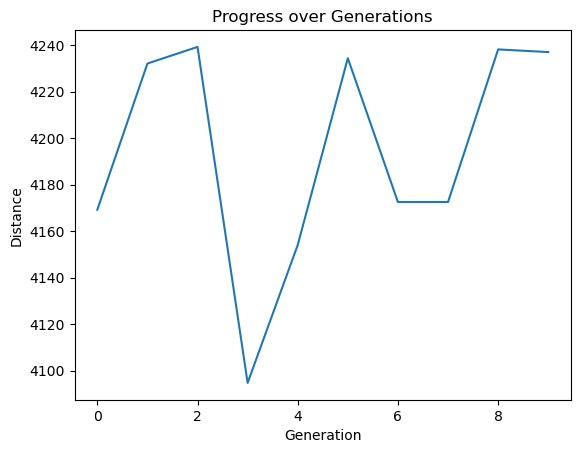

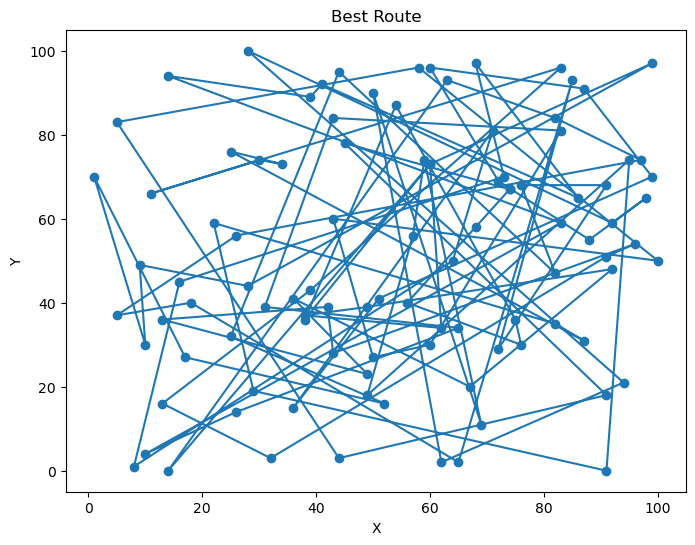

In [1]:
import random
import math
import matplotlib.pyplot as plt

# Set to True to print detailed debug output for each GA step.
VERBOSE = False

# Calculate Euclidean distance between two cities
def distance(city1, city2):
    return math.sqrt((city1[0] - city2[0]) ** 2 + (city1[1] - city2[1]) ** 2)

# Compute total distance of the route (returning to the starting city)
def total_distance(route, cities):
    d = 0.0
    for i in range(len(route)):
        city_a = cities[route[i]]
        city_b = cities[route[(i + 1) % len(route)]]
        d += distance(city_a, city_b)
    return d

# Create a random route (a random permutation of city indices)
def create_route(num_cities):
    route = list(range(num_cities))
    random.shuffle(route)
    if VERBOSE:
        print(f"Created route: {route}")
    return route

# Generate an initial population of routes
def initial_population(pop_size, num_cities):
    pop = [create_route(num_cities) for _ in range(pop_size)]
    if VERBOSE:
        print("\nInitial Population:")
        for i, route in enumerate(pop):
            print(f"Route {i}: {route}")
    return pop

# Rank routes in the population by fitness (1 / total_distance)
def rank_population(population, cities):
    fitness_results = {}
    for i, route in enumerate(population):
        fitness_results[i] = 1.0 / total_distance(route, cities)
    ranked = sorted(fitness_results.items(), key=lambda x: x[1], reverse=True)
    if VERBOSE:
        print("\nRanked Population (Route index: Fitness and Distance):")
        for idx, fit in ranked:
            print(f"Route {idx}: Fitness = {fit:.4f}, Distance = {total_distance(population[idx], cities):.2f}")
    return ranked

# Select a set of parent indices using elitism and roulette wheel selection
def selection(ranked_pop, elite_size):
    selection_results = []
    if VERBOSE:
        print("\nSelection Step:")
    # First add elite routes automatically
    for i in range(elite_size):
        selection_results.append(ranked_pop[i][0])
        if VERBOSE:
            print(f"Elite selected: Route {ranked_pop[i][0]}")
    
    # Prepare cumulative sum for roulette wheel selection
    fitness_values = [item[1] for item in ranked_pop]
    cumulative_sum = []
    current_sum = 0
    for f in fitness_values:
        current_sum += f
        cumulative_sum.append(current_sum)
    total_sum = cumulative_sum[-1]
    
    # Select the rest based on probability proportional to fitness
    for _ in range(len(ranked_pop) - elite_size):
        pick = random.random() * total_sum
        for j, cumulative in enumerate(cumulative_sum):
            if pick <= cumulative:
                selection_results.append(ranked_pop[j][0])
                if VERBOSE:
                    print(f"Roulette selected: Route {ranked_pop[j][0]}")
                break
    if VERBOSE:
        print("Selection Results (Indices):", selection_results)
    return selection_results

# Create a mating pool based on the selected indices
def mating_pool(population, selection_results):
    pool = [population[i] for i in selection_results]
    if VERBOSE:
        print("\nMating Pool:")
        for i, route in enumerate(pool):
            print(f"Pool Route {i}: {route}")
    return pool

# Perform ordered crossover between two parents to produce a child
def ordered_crossover(parent1, parent2):
    start = random.randint(0, len(parent1) - 2)
    end = random.randint(start + 1, len(parent1) - 1)
    if VERBOSE:
        print("\nOrdered Crossover:")
        print(f"Parent1: {parent1}")
        print(f"Parent2: {parent2}")
        print(f"Selected slice indices: {start} to {end}")
    
    child = [None] * len(parent1)
    # Copy a slice from parent1
    child[start:end+1] = parent1[start:end+1]
    if VERBOSE:
        print(f"Child after copying slice from Parent1: {child}")
    
    # Fill the remaining positions with genes from parent2 in order
    current_index = (end + 1) % len(parent1)
    p2_index = (end + 1) % len(parent1)
    while None in child:
        gene = parent2[p2_index]
        if gene not in child:
            child[current_index] = gene
            if VERBOSE:
                print(f"Inserting gene {gene} from Parent2 at index {current_index}")
            current_index = (current_index + 1) % len(parent1)
        p2_index = (p2_index + 1) % len(parent1)
    if VERBOSE:
        print(f"Resulting Child: {child}")
    return child

# Breed a new population using the mating pool
def breed_population(matingpool, elite_size):
    children = []
    length = len(matingpool)
    pool = random.sample(matingpool, len(matingpool))
    if VERBOSE:
        print("\nBreeding Population:")
    # Retain the elite individuals directly
    for i in range(elite_size):
        children.append(matingpool[i])
        if VERBOSE:
            print(f"Elite child carried over: {matingpool[i]}")
    # Breed the rest using crossover
    for i in range(elite_size, length):
        child = ordered_crossover(pool[i], pool[length - i - 1])
        children.append(child)
        if VERBOSE:
            print(f"Bred child: {child}")
    return children

# Mutate a single route with a given mutation rate (swap mutation)
def mutate(route, mutation_rate):
    if VERBOSE:
        print(f"\nMutating route: {route}")
    for swapped in range(len(route)):
        if random.random() < mutation_rate:
            swap_with = random.randint(0, len(route) - 1)
            if VERBOSE:
                print(f"Swapping index {swapped} and {swap_with}: {route[swapped]} <-> {route[swap_with]}")
            route[swapped], route[swap_with] = route[swap_with], route[swapped]
    if VERBOSE:
        print(f"Route after mutation: {route}")
    return route

# Apply mutation to the entire population
def mutate_population(population, mutation_rate):
    mutated_pop = [mutate(route, mutation_rate) for route in population]
    if VERBOSE:
        print("\nPopulation after Mutation:")
        for i, route in enumerate(mutated_pop):
            print(f"Route {i}: {route}")
    return mutated_pop

# Create the next generation by selection, breeding, and mutation
def next_generation(current_gen, elite_size, mutation_rate, cities):
    if VERBOSE:
        print("\n--- Next Generation ---")
    ranked_pop = rank_population(current_gen, cities)
    selection_results = selection(ranked_pop, elite_size)
    pool = mating_pool(current_gen, selection_results)
    children = breed_population(pool, elite_size)
    next_gen = mutate_population(children, mutation_rate)
    return next_gen

# Main genetic algorithm function
def genetic_algorithm(cities, pop_size, elite_size, mutation_rate, generations):
    population = initial_population(pop_size, len(cities))
    progress = []
    best_route = None
    best_distance = float('inf')
    
    for i in range(generations):
        if VERBOSE:
            print(f"\n===== Generation {i} =====")
        population = next_generation(population, elite_size, mutation_rate, cities)
        ranked = rank_population(population, cities)
        best_index = ranked[0][0]
        current_distance = total_distance(population[best_index], cities)
        progress.append(current_distance)
        if current_distance < best_distance:
            best_distance = current_distance
            best_route = population[best_index]
        if VERBOSE:
            print(f"Generation {i}: Best Distance = {current_distance:.2f}")
    
    return best_route, progress

# Example usage
if __name__ == "__main__":
    # Generate random cities; using 5 cities for brevity in the debug output.
    num_cities = 100
    cities = [(random.randint(0, 100), random.randint(0, 100)) for _ in range(num_cities)]
    print("Cities:")
    for idx, city in enumerate(cities):
        print(f"City {idx}: {city}")
    
    # GA parameters
    pop_size = 10000
    elite_size = 2
    mutation_rate = 0.02
    generations = 10
    
    best_route, progress = genetic_algorithm(cities, pop_size, elite_size, mutation_rate, generations)
    print("\nBest Route Found:", best_route)
    print("Best Distance:", total_distance(best_route, cities))
    
    # Plot the progress (distance over generations)
    plt.plot(progress)
    plt.xlabel("Generation")
    plt.ylabel("Distance")
    plt.title("Progress over Generations")
    plt.show()
    
    # Plot the best route found
    best_route_coords = [cities[i] for i in best_route]
    # Append the start city to complete the loop
    best_route_coords.append(cities[best_route[0]])
    xs, ys = zip(*best_route_coords)
    plt.figure(figsize=(8, 6))
    plt.plot(xs, ys, marker='o')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Best Route")
    plt.show()
